In [2]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7ec0393826cc9cfa161cbece2ba2150575e12cdaa7ad162980ea242cb28529ec
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from gensim.utils import simple_preprocess
import numpy as np
import gensim.parsing.preprocessing as pp

from gensim.models import Word2Vec, KeyedVectors
import gensim

from nltk.stem import WordNetLemmatizer
import plotly.express as px
import pymorphy2
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')



from pymystem3 import Mystem # для лемматизации
m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [4]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/python_for_analysis/"

Mounted at /content/drive


# Постановка задачи и загрузка данных

В рамках практики по обработке текста поработаем с реальными данными, содержательно близкими к данным с первой практики, - из Конструктора ОП. В этот раз поработаем с описанием дисциплин с помощью языковых моделей.


Задача на практику - предобработать датасет:
1. получить текстовое описание каждой дисциплины датасета
2. выполнить предобработку текстовых данных
3. построить для дисциплины вектор на основе word2vec
4. потестировать текстовые представления

Задач не много, но все затратные по времени.

In [1]:
!gdown 1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi

Downloading...
From: https://drive.google.com/uc?id=1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi
To: /content/df_up_courses_202308.csv
100% 1.88G/1.88G [00:13<00:00, 142MB/s]


Из информации о дисциплине у нас есть следующая:
1. course_id - номер дисциплины (может повторяться)
2. course_title - название дисциплины
3. description - краткое описание дисциплины
4. section - разделы дисциплины
5. topic - темы, входящие в раздел дисциплины
6. qualification - уровень образования (бакалавриат, магистратура, специалитет)
7. unit_id - айди факульета
8. up_id - айди учебного плана (образовательной прогарммы)
9. up_title - название учебного плана (образовательной прогарммы)
10. start_year - год набора
11. module_name - название модуля, в который входит дисциплина

In [5]:
df = pd.read_csv("/content/df_up_courses_202308.csv")
df.head()

,Unnamed: 0,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
0,0,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
1,1,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."
2,2,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,7014,Программирование и интернет-технологии,2020,"Специализация ""Разработка информационных систе..."
3,54,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
4,55,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."


## Предобработка датасета

Преобразуйте датасет так, чтобы одна строка описывала одну дисциплину в учебном плане. Отдельным столбцом должен храниться весь текст, который описывает дисциплину: description, section, topic. Без дубликатов содержания разделов и тем внутри дисциплины.

In [6]:
def unique_join(x):
    if isinstance(x, float) and pd.isna(x):
        return ' '
    return ' '.join(set(str(item) for item in x))

In [7]:
grouped_df = df.groupby(['course_id', 'qualification', 'up_id', 'unit_id', 'start_year', 'module_name'], as_index=False).agg({
    'course_title': 'first',
    'description': unique_join,
    'section': lambda x: ' '.join(set(x)),
    'topic': lambda x: ' '.join(set(x)),
    'up_title': 'first'
})

In [8]:
grouped_df['description_text'] =  grouped_df['description'] + ' ' + grouped_df['section'] + ' ' + grouped_df['topic']

In [9]:
unique_counts = pd.DataFrame(df.drop("Unnamed: 0", axis = 1).nunique().reset_index())
unique_counts.columns = ['Column', 'Unique Values']

fig = px.bar(unique_counts, x='Column', y='Unique Values',
             title='Количество уникальных значений по столбцам',
             labels={'Column': 'Столбцы', 'Unique Values': 'Количество уникальных значений'})
fig.show()

In [10]:
grouped_df = grouped_df[['course_id', 'course_title',  'qualification', 'unit_id', 'up_id', 'module_name', 'description_text']]

In [11]:
grouped_df.head(3)

,course_id,course_title,qualification,unit_id,up_id,module_name,description_text
0,2626,Философия,bachelor,8.0,6905,Модуль «Философия+Мышление»,Курс «Философия» даёт целостное представление ...
1,2626,Философия,bachelor,8.0,6938,Модуль обязательных дисциплин,Курс «Философия» даёт целостное представление ...
2,2626,Философия,bachelor,8.0,6974,Модуль обязательных дисциплин,Курс «Философия» даёт целостное представление ...


In [12]:
grouped_df.shape

(66076, 7)

In [13]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=f07f4b6f7f3f19e5585ba3b77cd9e7b3ead45e7ab840b703ab8c6fc9fc73a47b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [14]:
from langdetect import detect, DetectorFactory

def is_english(text):
    if 'e' in text:
      return True

    return False

df_eng = grouped_df['description_text'].apply(is_english)

df_eng.sum()

26608

Преобразования выполняются не слишком быстро, рекомендую сохраниться.

## Предобработка описания дисциплины

Пора поработать со столбцом с текстовым содержанием дисциплины. Минимально понадобятся следующие шаги предобработки:
1. Токенизация
2. Удаление пунктуации
3. Лемматизация
4. Удаление лишних пробелов внутри текста

Чтобы не слишком углубляться в предобработку, рекомендую воспользоваться реализованными в gensim методами. Примеры можно найти в ноутбуке по ссылке: https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing

In [29]:
def tokenize(text):
  text = text.lower()
  return re.findall(r'\b\w+\b', text)

df_token = grouped_df['description_text'].apply(tokenize)
df_token = pd.DataFrame(df_token)
df_token.head

<bound method NDFrame.head of                                         description_text
0      [курс, философия, даёт, целостное, представлен...
1      [курс, философия, даёт, целостное, представлен...
2      [курс, философия, даёт, целостное, представлен...
3      [курс, философия, даёт, целостное, представлен...
4      [курс, философия, даёт, целостное, представлен...
...                                                  ...
66071  [дисциплина, основы, планирования, научных, ис...
66072  [the, course, basics, of, research, planning, ...
66073  [дифференциальные, уравнения, являются, мощным...
66074  [целью, освоения, дисциплины, является, достиж...
66075  [целью, освоения, дисциплины, является, достиж...

[66076 rows x 1 columns]>

In [34]:
from nltk.corpus import stopwords

In [35]:
lematizer_en = WordNetLemmatizer()
morph_ru = pymorphy2.MorphAnalyzer()
stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))

def process_text(text):

    processed_words = []

    for word in text:
        # lang = detect(word)

        # if lang == 'ru':
        lemma = morph_ru.parse(word)[0].normal_form
        if lemma not in stop_words_ru and lemma not in stop_words_en:
            processed_words.append(lemma)
        # elif lang == 'en':
        #     doc = nlp_en(word)
        #     for token in doc:
        #         lemma = token.lemma_
        #         if lemma.lower() not in stop_words_en:
        #             processed_words.append(lemma.lower())

    return processed_words

df_token = df_token["description_text"].apply(process_text)
df_token

0        [курс, философия, давать, целостный, представл...
1        [курс, философия, давать, целостный, представл...
2        [курс, философия, давать, целостный, представл...
3        [курс, философия, давать, целостный, представл...
4        [курс, философия, давать, целостный, представл...
                               ...                        
66071    [дисциплина, основа, планирование, научный, ис...
66072    [course, basics, research, planning, managemen...
66073    [дифференциальный, уравнение, являться, мощный...
66074    [цель, освоение, дисциплина, являться, достиже...
66075    [цель, освоение, дисциплина, являться, достиже...
Name: description_text, Length: 66076, dtype: object

In [ ]:
df_with_text = grouped_df.copy()
df_with_text["description_text"] = df_token


In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        print(f'Epoch {self.epoch}')
        self.epoch += 1

Не будет лишним в этот момент сохраниться. Лемматизация выполняется сравнительно долго.

In [36]:
# обучим на своих данных модель word2vec
model_w2v = Word2Vec(df_token.to_list(), # данные
                       min_count=1,      # минимальная частота слова в корпусе
                       vector_size=200,  # размер вектора для слова
                       workers=4,        # количество потоков
                       window=10,
                       sg = 1)        # окно, в которое попадает слово

In [ ]:
model_path = way + "/lessons_w2v_model" # будет удобно сохранить модель
model_w2v.save(model_path)

In [ ]:
# так выглядит один вектор
model_w2v.wv.get_vector("обучение")

array([ 0.14390925,  0.0763056 ,  0.03356951,  0.38166428, -0.1286096 ,
       -0.1089496 ,  0.14299902,  0.35877368,  0.08852571, -0.15806143,
       -0.44658765,  0.18305194, -0.03232301, -0.09417211,  0.2798047 ,
       -0.15873176,  0.64817494, -0.01072012, -0.8052516 , -0.21596459,
       -0.05156204, -0.06720179,  0.6473965 , -0.5943989 , -0.26301596,
        0.27270737,  0.01058037,  0.25131008,  0.10702142,  0.20800585,
        0.69986284,  0.16894194,  0.32679123, -0.15078288,  0.04349436,
       -0.1466339 ,  0.16299336, -0.11928907, -0.3793431 ,  0.19753665,
        0.06165942, -0.01851775, -0.16884196, -0.25066927,  0.77947396,
        0.15765318, -0.39261812, -0.40594485,  0.5567804 ,  0.24439831,
        0.37629163,  0.3284092 , -0.08285139,  0.35346076,  0.1235699 ,
        0.4398949 ,  0.14124179,  0.00334839, -0.15542008, -0.05089536,
        0.01063791, -0.309344  ,  0.13886039, -0.03530718, -0.5986428 ,
        0.03471621,  0.10793725,  0.15975195, -0.63258946,  0.26

Какая-то загадка с отупевшими леммами

In [ ]:
# слова, максимально близкие к "машинному обучению"
model_w2v.wv.most_similar(["машинный"])

[('обучение', 0.6656073331832886),
 ('изучаютcть', 0.5953994989395142),
 ('углубляться', 0.5487757921218872),
 ('предсказательный', 0.5386382937431335),
 ('guns', 0.5235428214073181),
 ('соверменный', 0.5228084325790405),
 ('ocaml', 0.522129237651825),
 ('аудиоаналитик', 0.5155125260353088),
 ('дифуззионный', 0.5129229426383972),
 ('cреда', 0.5123465061187744)]

In [ ]:
class Word2VecTransformer:

    def __init__(self, w2v_model, word_pattern=r'\b\w+\b'):

        self.w2v_model = w2v_model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):

        X_transformed = np.zeros((len(X), self.w2v_model.wv.vector_size))
        for i, title in enumerate(X):

            title_vector = np.zeros((self.w2v_model.wv.vector_size,))
            tokens = title
            if len(tokens) == 0:
              continue

            for token in tokens:
                if token in self.w2v_model.wv.key_to_index:
                    title_vector += self.w2v_model.wv.get_vector(token)

            X_transformed[i] = title_vector / len(tokens)

        return X_transformed

w2v_transformer = Word2VecTransformer(w2v_model=model_w2v)


embedings = w2v_transformer.transform(df_with_text["description_text"].values)

In [ ]:
df_with_text = pd.concat([df_with_text, pd.DataFrame(embedings)], axis = 1)
df_with_text.head()

,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,2626,Философия,bachelor,8.0,6905,Модуль «Философия+Мышление»,"[курс, философия, давать, целостный, представл...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
1,2626,Философия,bachelor,8.0,6938,Модуль обязательных дисциплин,"[курс, философия, давать, целостный, представл...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
2,2626,Философия,bachelor,8.0,6974,Модуль обязательных дисциплин,"[курс, философия, давать, целостный, представл...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
3,2626,Философия,bachelor,8.0,7014,Модуль обязательных дисциплин,"[курс, философия, давать, целостный, представл...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
4,2626,Философия,bachelor,8.0,7136,Модуль обязательных дисциплин,"[курс, философия, давать, целостный, представл...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036


In [ ]:
df_with_text.to_csv('df_milled.csv', index=False)

Не забываем сохраниться!

# Задание на ЛР2

In [5]:
df_milled = pd.read_csv(way + "df_milled.csv")
df_milled.shape

(66076, 207)

С предобработанными данными попытаемся решить следующие задачи:

1. Определить предметные области дисциплин через кластеризацию. Используем два классических алгоритма: k-means и иерархическую кластеризацию.
2. Найти дисциплины, которые выбиваются из учебного плана. Для этого построим эмбеддинг учебного плана (усредним эмбеддинги всех его дисциплин) и найдем дисциплины, у которых минимальное косинусное сходство с эмбеддингом учебного плана.
3. Оценить, насколько удачно будет генерировать содержание дисциплины LLM. Структура описания дисциплины не важна. Важно содержание. Сравнивать будем эмбеддинги снова через косинусное сходство.

## Кластеризация дисциплин

Удалим дубликаты, т.к. нас интересует только содержательный аспект в данной задаче.

In [6]:
df_to_clust = df_milled.drop_duplicates(subset=["course_id"], keep="first").reset_index().drop("index", axis = 1)
f"{df_milled.shape} -> {df_to_clust.shape}"

'(66076, 207) -> (7118, 207)'

In [7]:
df_to_clust.head()

,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,2626,Философия,bachelor,8.0,6905,Модуль «Философия+Мышление»,"['курс', 'философия', 'давать', 'целостный', '...",0.015387,-0.351841,0.010150,...,-0.198080,0.097472,-0.172852,-0.181640,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
1,2627,Введение в цифровую культуру и программирование,bachelor,14.0,7146,Модуль обязательных дисциплин,"['курс', 'введение', 'цифровой', 'культура', '...",0.021276,-0.341782,-0.100103,...,-0.265347,0.033977,-0.000471,-0.160973,0.006920,0.015908,0.034780,-0.275419,0.155153,-0.234927
2,2628,Проектирование баз данных,bachelor,14.0,6881,Модуль «Цифровая культура»,"['дисциплина', 'направить', 'формирование', 'п...",-0.134249,-0.361925,-0.152875,...,-0.142958,-0.069168,-0.293787,-0.163966,0.261609,0.173180,-0.069932,-0.054309,0.004292,-0.227187
3,2631,Современные вопросы информатики,bachelor,14.0,6881,Модуль «Цифровая культура»,"['дисциплина', 'направить', 'формирование', 'с...",-0.139399,-0.262457,0.049808,...,-0.073468,-0.054972,-0.078013,-0.203648,0.066289,0.112671,-0.031275,-0.061428,-0.066783,-0.211998
4,2635,Иностранный язык,bachelor,9.0,6859,Модуль «Soft Skills»,"['цель', 'освоение', 'дисциплина', 'являться',...",0.066761,-0.355328,-0.044078,...,-0.207485,-0.020898,-0.020644,-0.053316,0.243068,-0.228492,0.332060,-0.026609,0.049435,-0.204836


In [8]:
X = df_to_clust.drop(columns=['course_id', 'course_title', 'qualification', 'unit_id', 'up_id',
       'module_name', 'description_text'])
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.015387,-0.351841,0.010150,0.085453,0.034368,-0.241575,0.044407,0.323028,0.017059,-0.191664,...,-0.198080,0.097472,-0.172852,-0.181640,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
1,0.021276,-0.341782,-0.100103,0.287487,0.123079,-0.367663,-0.019323,0.301261,-0.047935,-0.120236,...,-0.265347,0.033977,-0.000471,-0.160973,0.006920,0.015908,0.034780,-0.275419,0.155153,-0.234927
2,-0.134249,-0.361925,-0.152875,0.314800,0.105056,-0.296284,-0.174314,0.500124,-0.009755,-0.162353,...,-0.142958,-0.069168,-0.293787,-0.163966,0.261609,0.173180,-0.069932,-0.054309,0.004292,-0.227187


### Изменение размерности

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig = px.scatter(x=X_pca[:,0], y=X_pca[:,1],
                 title='PCA результаты',
                 labels={'x': 'TSNE 1', 'y': 'TSNE 2'})
fig.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7118 samples in 0.008s...
[t-SNE] Computed neighbors for 7118 samples in 1.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7118
[t-SNE] Computed conditional probabilities for sample 2000 / 7118
[t-SNE] Computed conditional probabilities for sample 3000 / 7118
[t-SNE] Computed conditional probabilities for sample 4000 / 7118
[t-SNE] Computed conditional probabilities for sample 5000 / 7118
[t-SNE] Computed conditional probabilities for sample 6000 / 7118
[t-SNE] Computed conditional probabilities for sample 7000 / 7118
[t-SNE] Computed conditional probabilities for sample 7118 / 7118
[t-SNE] Mean sigma: 0.536880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.934128
[t-SNE] KL divergence after 300 iterations: 2.363957


In [ ]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1],
                 title='t-SNE результаты',
                 labels={'x': 'TSNE 1', 'y': 'TSNE 2'})
fig.show()

In [ ]:
course_checker = pd.concat([df_to_clust["course_title"], pd.DataFrame(tsne_results)], axis = 1)
course_checker.sample(10)

,course_title,0,1
211,Дизайн вещей будущего,-1.966213,-1.996332
6385,Введение в вычислительное музыковедение,-7.147991,-1.673756
5188,Язык Python для анализа данных,-8.397759,-3.127486
5792,Методы молекулярной динамики и математический ...,9.748478,-0.873151
6532,Метаболическая инженерия,6.189406,6.420448
6718,Китайский язык 2,1.124020,-10.737967
5760,Математическое моделирование процессов в клима...,-2.050281,0.383969
6341,Китайский язык 1,1.050222,-11.280392
133,История искусств,0.761206,-6.482956
4050,Процессы и технологии разделения и глубокой оч...,8.782883,2.827085


In [ ]:
tsne2 = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results2 = tsne2.fit_transform(X)

fig = px.scatter(
    x=tsne_results2[:,0], y=tsne_results2[:,1],
    title='t-SNE результаты 2',
    labels={'x': 'TSNE 1', 'y': 'TSNE 2'}
)
fig.show()

### k-means

7к объектов - небольшое количество для кластеризации, обучение будет проходить достаточно быстро. Начнем с k-means. В качестве меры сходства будем использовать косинусное расстояние. Другие виды расстояния будут мало репрезентативны на векторах размером 300.

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10,           # ни на чем не основанное предположение, что у нас 10 кластеров
                random_state=0,
                n_init="auto",
                algorithm="lloyd").fit(X) # lloyd означает, что возьмем не совсем k-means, а ЕМ - более общую версию алгоритма
kmeans.labels_

array([7, 6, 9, ..., 3, 5, 6], dtype=int32)

In [ ]:
df_to_clust["cluster"] = kmeans.labels_

<ipython-input-13-9d0e96553b6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_clust["cluster"] = kmeans.labels_


In [ ]:
df_to_clust.cluster.value_counts()

2    1270
8     948
6     919
0     829
5     694
9     678
7     671
4     402
3     376
1     331
Name: cluster, dtype: int64

Разделение на кластеры получилось удивительно ровное. Посмотрим, будет ли какой-то смысл в примерах объектов кластеров.

> **В коде ниже берутся первые 5 примеров. Посмотрите, что будет на случайных подвыборках.**

In [ ]:
for i in range(kmeans.n_clusters):
  display(df_to_clust.loc[df_to_clust.cluster == i].head(5))

,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
3270,2787,"Метрология, стандартизация и сертификация",bachelor,12.0,6895,"Специализация ""Вычислительные системы""","['дисциплина', 'направить', 'получение', 'студ...",-0.055487,-0.256244,-0.134552,...,0.012818,-0.062779,-0.225761,0.156782,-0.055158,0.048438,-0.246250,-0.074581,-0.365778,0
3416,2830,Экология,bachelor,6.0,6902,Естественнонаучный модуль,"['содержание', 'дисциплина', 'охватывать', 'кр...",0.034522,-0.296261,0.126850,...,-0.010404,-0.107809,-0.167563,0.085902,-0.119794,0.113590,-0.042321,-0.031953,-0.234367,0
3447,2838,Проектный менеджмент,bachelor,17.0,6902,Элективный модуль по группе направлений,"['дисциплина', 'проектный', 'менеджмент', 'охв...",0.013495,-0.293060,-0.166897,...,0.047552,-0.075494,-0.090954,-0.016617,0.121146,-0.003849,0.013006,-0.041682,-0.232725,0
3729,2946,Экономика программной инженерии,bachelor,12.0,6898,Модуль обязательных дисциплин,"['дисциплина', 'экономика', 'программный', 'ин...",0.040030,-0.277174,-0.043022,...,0.176842,-0.016247,0.010048,0.105297,0.096106,0.079203,-0.131782,0.024351,-0.146705,0
3803,2968,Инновационный маркетинг,bachelor,1.0,6885,ОГНП 4: Предпринимательство и инноватика,"['дисциплина', 'призвать', 'обеспечить', 'теор...",-0.017497,-0.273108,-0.035706,...,0.063270,-0.057056,-0.158382,0.125996,0.044481,0.049986,-0.076206,0.113413,-0.173305,0


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
7854,4697,Обработка и анализ данных / Data Processing an...,master,7.0,7021,Цифровая культура в предметной области мегафак...,"['discipline', 'data', 'processing', 'analysis...",0.240819,-0.372157,0.144323,...,0.141005,-0.144694,-0.014406,0.198250,0.062774,-0.125504,0.282388,0.375081,-0.284255,1
7875,4722,Обработка и анализ данных / Data Processing an...,master,7.0,6861,Цифровая культура в предметной области мегафак...,"['discipline', 'data', 'processing', 'analysis...",0.240819,-0.372157,0.144323,...,0.141005,-0.144694,-0.014406,0.198250,0.062774,-0.125504,0.282388,0.375081,-0.284255,1
8205,4724,Прикладной искусственный интеллект (базовый ур...,master,7.0,6861,Цифровая культура в предметной области мегафак...,"['aim', 'discipline', 'applied', 'artificial',...",0.105199,-0.428487,0.122800,...,0.105900,-0.138305,-0.114924,0.221415,0.203469,0.052295,0.153125,0.265886,-0.222954,1
8535,4726,Прикладной искусственный интеллект (продвинуты...,master,7.0,6861,Цифровая культура в предметной области мегафак...,"['aim', 'discipline', 'applied', 'artificial',...",0.102352,-0.428527,0.125212,...,0.073171,-0.133929,-0.130017,0.214325,0.216670,0.066046,0.152665,0.249997,-0.229988,1
9337,4975,Геоинформационные навигационные системы и техн...,master,2.0,7030,Профильный профессиональный модуль,"['knowledge', 'basic', 'meters', 'astronomical...",0.166963,-0.200865,0.086840,...,0.112805,-0.036648,0.061072,0.279968,0.044267,0.184627,0.268185,0.326285,-0.124861,1


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
823,2651,Лазерные технологии,bachelor,50.0,6860,ОГНП 7: Фотоника,"['цель', 'освоение', 'дисциплина', 'лазерный',...",-0.304061,-0.222821,-0.115440,...,0.068267,-0.164347,-0.001704,0.191005,0.050449,-0.058467,-0.109870,0.005234,-0.212489,2
3275,2788,Телекоммуникационные системы,bachelor,12.0,6895,"Специализация ""Распределенные системы и сети""","['задача', 'дисциплина', 'являться', 'формиров...",-0.406965,-0.081206,0.090953,...,-0.088675,-0.088919,-0.237579,0.284504,-0.001034,0.050403,-0.097283,0.019435,-0.173156,2
4099,3110,Основы взаимозаменяемости,bachelor,2.0,6893,Профильный профессиональный модуль,"['структура', 'организация', 'единый', 'систем...",-0.066236,-0.064227,0.013908,...,-0.018688,-0.366994,0.026134,0.416978,0.223951,0.124218,-0.150483,0.158441,-0.384030,2
4117,3115,Технологии приборостроения,bachelor,2.0,6893,Профильный профессиональный модуль,"['рамка', 'дисциплина', 'рассматриваться', 'ос...",-0.257235,-0.215515,-0.090905,...,0.039681,-0.337900,-0.059996,0.293041,0.071047,-0.070883,-0.110728,-0.135378,-0.278268,2
4243,3151,Теоретическая и прикладная механика,bachelor,2.0,6859,Элективный модуль по группе направлений,"['дисциплина', 'являться', 'комплексный', 'пре...",-0.085513,-0.070395,-0.033483,...,0.069404,-0.237369,-0.078420,0.156778,0.004440,0.171661,-0.208341,0.106033,-0.342714,2


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
7429,4625,Мышление (Научная рациональность и общество) /...,master,8.0,6861,Общеуниверситетская дисциплина мировоззренческ...,"['students', 'course', 'trained', 'able', 'dec...",0.131687,-0.498659,0.107442,...,0.033242,-0.220860,0.277432,0.230145,-0.000537,0.035044,0.165783,0.165657,-0.328254,3
8729,4757,Креативные технологии / Creative Technologies,master,15.0,6861,Общеуниверситетская дисциплина мировоззренческ...,"['course', 'teach', 'creativity', 'ability', '...",0.100934,-0.260644,0.042526,...,0.124051,0.112986,0.091509,0.020173,0.183836,0.222717,0.256714,0.178086,-0.214580,3
8891,4758,Создание технологического бизнеса / High Tech ...,master,21.0,6861,Общеуниверситетская дисциплина мировоззренческ...,"['module', 'aims', 'develop', 'students', 'pro...",0.339206,-0.304343,0.219268,...,0.344376,-0.053873,0.097828,0.234299,0.254473,0.225069,0.152104,0.385031,-0.204113,3
9088,4830,"Создание, внедрение и продвижение новых технол...",master,28.0,6861,"Специализация ""Технологическое брокерство в об...","['students', 'know', 'describe', 'ways', 'inte...",0.426614,-0.190498,0.262934,...,0.225690,0.002228,0.094889,0.268379,0.399543,0.068287,0.058147,0.358748,-0.156515,3
9092,4836,Доклинические исследования / Preclinical studies,master,28.0,6861,Факультативные дисциплины,"['students', 'know', 'formulate', 'basic', 'pr...",0.156599,-0.101628,0.196657,...,0.110594,-0.172806,-0.013697,0.546549,0.203970,0.288022,0.163984,0.405571,-0.254228,3


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
9085,4803,Исследование альтернативных источников энергии...,master,6.0,7078,"Специализация ""Чистое производство / Cleaner P...","['aim', 'discipline', 'form', 'students', 'kno...",0.191612,-0.123528,-0.009737,...,0.479799,-0.063566,0.106829,0.136784,0.173741,0.383977,0.082034,0.179404,0.049727,4
9087,4818,Неорганическая химия материалов / Inorganic ch...,master,28.0,6970,Профессиональный модуль,"['students', 'know', 'reproduce', 'methods', '...",0.131127,-0.330524,0.106216,...,0.134792,-0.036077,0.135271,0.342066,-0.056714,0.257039,0.250187,0.170631,-0.281056,4
9130,4845,Основы клеточного метаболизма и сигналинга / F...,master,28.0,6861,Факультативные дисциплины,"['students', 'know', 'structural', 'functional...",0.061610,-0.186097,0.288621,...,0.081405,-0.139742,0.173959,0.360350,0.223795,0.252325,0.198600,0.392617,-0.193495,4
9403,5086,Визуализация / Visualisation,master,30.0,7054,Факультативные дисциплины,"['classes', 'students', 'gain', 'base', 'diffe...",0.116731,-0.165082,0.067395,...,0.129436,-0.127676,0.133181,0.252046,0.154301,0.294393,0.125517,0.379032,-0.117774,4
9405,5087,Световые устройства и системы управления / Lig...,master,30.0,7054,Факультативные дисциплины,"['discipline', 'consider', 'history', 'lightin...",0.234072,-0.215689,0.122548,...,0.201585,-0.095320,0.194159,0.276229,0.087469,0.310536,0.182136,0.322372,-0.072198,4


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
942,2652,Линейная алгебра,bachelor,2.0,6905,Математический модуль,"['результат', 'освоение', 'курс', 'студент', '...",-0.220178,-0.058975,-0.118047,...,-0.006822,-0.284767,-0.144584,0.069724,-0.169611,0.113108,-0.166405,-0.053368,-0.223357,5
946,2653,Математический анализ,bachelor,14.0,6881,Математический модуль,"['nan', 'многократный', 'интеграл', 'риман', '...",-0.072698,-0.106432,0.096504,...,-0.138756,-0.223315,-0.089905,0.303850,-0.180230,0.065222,-0.084963,0.209793,-0.519557,5
950,2654,Дискретная математика,bachelor,14.0,6881,Математический модуль,"['рамка', 'изучение', 'дать', 'дисциплина', 'р...",-0.170934,-0.301415,-0.126501,...,-0.055593,-0.048504,0.007303,0.126391,-0.150292,0.126070,-0.085400,-0.058029,-0.281023,5
958,2655,Дополнительные главы высшей математики,bachelor,2.0,6905,Математический модуль,"['дисциплина', 'дополнительный', 'глава', 'выс...",-0.145825,-0.157499,-0.040056,...,-0.069102,-0.139217,-0.179554,0.249885,-0.166776,0.098026,-0.171862,-0.004401,-0.371316,5
1623,2678,Дополнительные главы линейной алгебры,bachelor,2.0,6881,Профильный профессиональный модуль,"['результат', 'освоение', 'курс', 'студент', '...",-0.220178,-0.058975,-0.118047,...,-0.006822,-0.284767,-0.144584,0.069724,-0.169611,0.113108,-0.166405,-0.053368,-0.223357,5


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
6,2627,Введение в цифровую культуру и программирование,bachelor,14.0,7146,Модуль обязательных дисциплин,"['курс', 'введение', 'цифровой', 'культура', '...",0.021276,-0.341782,-0.100103,...,0.033977,-0.000471,-0.160973,0.006920,0.015908,0.034780,-0.275419,0.155153,-0.234927,6
250,2641,Основы проектирования киберфизических систем,bachelor,2.0,6859,ОГНП 2: Киберфизические системы и технологи,"['общий', 'умный', 'чайник', 'металлургический...",-0.080590,-0.228693,0.004060,...,0.050062,-0.117100,-0.077077,0.205811,-0.109684,0.045389,-0.111068,0.030723,-0.272417,6
366,2642,Методы и средства программного обеспечения,All_levels,12.0,6859,ОГНП 3: Компьютерные технологии,"['дициплина', 'предназначить', 'изучение', 'ст...",-0.079015,-0.430478,-0.050428,...,-0.009712,-0.110568,-0.115065,0.085356,0.153980,0.047128,-0.161650,0.012515,-0.328828,6
486,2643,Основы кибербезопасности,bachelor,13.0,6859,ОГНП 3: Компьютерные технологии,"['данный', 'курс', 'студент', 'ознакомиться', ...",-0.136285,-0.252071,0.070200,...,-0.050344,-0.061580,-0.130161,0.164790,-0.073104,0.112058,-0.179057,-0.049497,-0.239130,6
983,2660,Проектирование программного обеспечения,bachelor,14.0,6881,Элективный модуль по группе направлений,"['дисциплина', 'направить', 'формирование', 'с...",-0.068333,-0.344781,-0.041653,...,0.038936,-0.125322,-0.107060,0.075333,0.135953,0.034864,-0.171490,0.071058,-0.258735,6


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
0,2626,Философия,bachelor,8.0,6905,Модуль «Философия+Мышление»,"['курс', 'философия', 'давать', 'целостный', '...",0.015387,-0.351841,0.010150,...,0.097472,-0.172852,-0.181640,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036,7
14,2635,Иностранный язык,bachelor,9.0,6859,Модуль «Soft Skills»,"['цель', 'освоение', 'дисциплина', 'являться',...",0.066761,-0.355328,-0.044078,...,-0.020898,-0.020644,-0.053316,0.243068,-0.228492,0.332060,-0.026609,0.049435,-0.204836,7
92,2637,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,6859,Модуль «Soft Skills»,"['данный', 'курс', 'сформировать', 'основа', '...",-0.105393,-0.207859,0.002915,...,-0.155268,-0.138087,-0.105414,0.005949,0.020925,0.022057,-0.250022,0.055893,-0.297759,7
995,2662,Иностранный язык в профессиональной деятельности,bachelor,9.0,6890,Иностранный язык в профессиональной деятельности,"['цель', 'освоение', 'дисциплина', 'являться',...",-0.015602,-0.185116,-0.043606,...,-0.241579,-0.202194,-0.237166,0.308427,-0.161106,0.224549,-0.214760,0.029386,-0.058193,7
1640,2723,Введение в цифровую культуру,bachelor,7.0,6859,Модуль «Цифровая культура»,"['сегодня', 'знание', 'цифровой', 'культура', ...",-0.093951,-0.218224,-0.046166,...,-0.036466,-0.022496,-0.197130,0.118039,-0.245758,0.115604,-0.168682,-0.001929,-0.209267,7


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
11,2631,Современные вопросы информатики,bachelor,14.0,6881,Модуль «Цифровая культура»,"['дисциплина', 'направить', 'формирование', 'с...",-0.139399,-0.262457,0.049808,...,-0.054972,-0.078013,-0.203648,0.066289,0.112671,-0.031275,-0.061428,-0.066783,-0.211998,8
134,2640,Теория автоматического управления,bachelor,2.0,6859,ОГНП 2: Киберфизические системы и технологи,"['дисциплина', 'охватывать', 'круг', 'вопрос',...",-0.189397,-0.345226,0.008048,...,-0.004430,-0.153969,-0.262542,0.158391,-0.150075,-0.077350,-0.100482,0.039979,-0.276570,8
606,2646,Современные инструменты анализа данных,bachelor,17.0,6859,ОГНП 6: Трансляционные информационные технологии,"['дисциплина', 'представить', '4', 'раздел', '...",-0.192794,-0.275693,-0.114528,...,-0.025957,-0.147153,-0.228443,0.111344,0.003884,-0.063334,-0.126563,-0.007005,-0.174999,8
820,2649,Алгоритмы на графах,bachelor,14.0,6929,ОГНП 6: Трансляционные информационные технологии,"['nan', 'связность', 'граф', 'задача', 'паросо...",-0.135107,-0.300599,0.049885,...,-0.146292,0.005547,0.109436,0.512785,-0.213893,0.048738,0.070941,0.049769,-0.303007,8
959,2656,Математическое и имитационное моделирование в ...,bachelor,14.0,6881,Естественнонаучный модуль,"['рамка', 'дисциплина', 'студент', 'знакомитьс...",-0.197698,-0.317186,0.075739,...,0.043779,-0.193183,-0.111334,0.222834,0.100118,-0.122180,-0.204998,-0.097834,-0.211117,8


,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,191,192,193,194,195,196,197,198,199,cluster
7,2628,Проектирование баз данных,bachelor,14.0,6881,Модуль «Цифровая культура»,"['дисциплина', 'направить', 'формирование', 'п...",-0.134249,-0.361925,-0.152875,...,-0.069168,-0.293787,-0.163966,0.261609,0.173180,-0.069932,-0.054309,0.004292,-0.227187,9
732,2647,UNIX/Linux системы в инфокоммуникациях,bachelor,17.0,6885,ОГНП 6: Трансляционные информационные технологии,"['это', 'курс', 'изучить', 'фундаментальный', ...",0.061404,-0.172496,-0.078931,...,-0.074970,-0.201364,-0.281722,0.075574,-0.204610,0.190764,-0.258813,0.088943,-0.238629,9
971,2658,Программирование,bachelor,14.0,7014,Модуль обязательных дисциплин,"['рамка', 'изучение', 'дисциплина', 'рассматри...",-0.214288,-0.362908,-0.169768,...,0.067137,-0.217902,-0.069781,0.333565,-0.103484,0.033582,-0.156815,0.033229,-0.243445,9
973,2659,Операционные системы,bachelor,14.0,6881,Общепрофессиональный модуль,"['дисциплина', 'сконцентрировать', 'восприятие...",-0.100919,-0.264430,-0.046437,...,0.068542,-0.020019,-0.241311,0.178757,-0.043602,0.108169,-0.109444,0.009574,-0.254415,9
1031,2663,Методы трансляции,bachelor,14.0,6881,Цифровая культура в профессиональной деятельно...,"['дисциплина', 'направить', 'изучение', 'основ...",-0.233963,-0.556345,-0.144989,...,0.165995,-0.155831,0.067921,0.372584,-0.050038,0.160219,-0.042204,-0.225869,-0.128478,9


Видно, что не только по количеству объектов, но и содержательно кажется, что разбиение в целом адекватное. Оцените качество кластеризации с помощью метрики "силуэт" из sklearn.

In [10]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
print( "For n_clusters =",
      10,
       "The average silhouette_score is :",
       silhouette_avg,
       )

For n_clusters = 10 The average silhouette_score is : 0.06646369693286001


Подберите оптимальное количество кластером по методу локтя. Протестируйте результат и оцените качество кластеризации с оптимальным количеством кластеров.

In [ ]:
from sklearn.metrics import silhouette_score

# Попробуем разное количество кластеров от 2 до 10
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init = 15, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    print(f"For n_clusters={k}, the silhouette score is {silhouette_avg}")


For n_clusters=2, the silhouette score is 0.4771298177607658
For n_clusters=3, the silhouette score is 0.16166172964445902
For n_clusters=4, the silhouette score is 0.14091436412794503
For n_clusters=5, the silhouette score is 0.14181480183384407
For n_clusters=6, the silhouette score is 0.14180181304967868
For n_clusters=7, the silhouette score is 0.08981210759329473
For n_clusters=8, the silhouette score is 0.08746662357365657
For n_clusters=9, the silhouette score is 0.08387088909914944


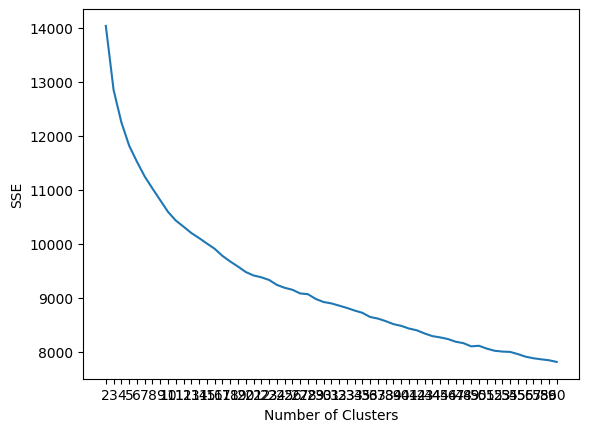

In [ ]:
kmeans_kwargs = {
"init": "random",
"n_init": 15,
"random_state": 42,
}

sse = []
for k in range(2, 61):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs, algorithm="lloyd")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 61), sse)
plt.xticks(range(2, 61))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
fig = px.line(x=range(2, len(sse) + 2), y=sse, markers=True, title='SSE vs. Number of Clusters')
fig.update_xaxes(title_text='Number of Clusters')
fig.update_yaxes(title_text='SSE')
fig.show()

In [12]:
kmeans = KMeans(n_clusters=20,
                random_state=0,
                n_init="auto",
                algorithm="lloyd").fit(X)
kmeans.labels_

array([16, 14, 10, ..., 13,  5,  0], dtype=int32)

In [13]:
df_to_clust["cluster"] = kmeans.labels_

In [14]:
df_to_clust.cluster.value_counts()

0     689
15    519
5     473
10    444
18    442
2     438
12    411
4     408
17    364
1     331
19    329
16    314
9     312
11    305
14    273
8     258
7     225
6     214
3     211
13    158
Name: cluster, dtype: int64

In [22]:
for i in range(kmeans.n_clusters):
  display(f'cluster: {i}')
  display(df_to_clust.loc[df_to_clust.cluster == i][["course_title", "module_name"]].head(3))

'cluster: 0'

,course_title,module_name
7,Основы проектирования киберфизических систем,ОГНП 2: Киберфизические системы и технологи
23,Проектирование информационных систем,Элективный модуль по группе направлений
43,Анализ и проектирование на UML,"Специализация ""Информационные системы и технол..."


'cluster: 1'

,course_title,module_name
814,Обработка и анализ данных / Data Processing an...,Цифровая культура в предметной области мегафак...
824,Обработка и анализ данных / Data Processing an...,Цифровая культура в предметной области мегафак...
826,Прикладной искусственный интеллект (базовый ур...,Цифровая культура в предметной области мегафак...


'cluster: 2'

,course_title,module_name
13,Лазерные технологии,ОГНП 7: Фотоника
235,Оптика - 2 (Геометрическая оптика),Элективный модуль по группе направлений
236,Лазерная фотоника,Факультетский модуль


'cluster: 3'

,course_title,module_name
842,Создание технологического бизнеса / High Tech ...,Общеуниверситетская дисциплина мировоззренческ...
855,"Создание, внедрение и продвижение новых технол...","Специализация ""Технологическое брокерство в об..."
856,Доклинические исследования / Preclinical studies,Факультативные дисциплины


'cluster: 4'

,course_title,module_name
853,Исследование альтернативных источников энергии...,"Специализация ""Чистое производство / Cleaner P..."
854,Неорганическая химия материалов / Inorganic ch...,Профессиональный модуль
858,Основы клеточного метаболизма и сигналинга / F...,Факультативные дисциплины


'cluster: 5'

,course_title,module_name
12,Алгоритмы на графах,ОГНП 6: Трансляционные информационные технологии
14,Линейная алгебра,Математический модуль
15,Математический анализ,Математический модуль


'cluster: 6'

,course_title,module_name
9,Основы кибербезопасности,ОГНП 3: Компьютерные технологии
21,Операционные системы,Общепрофессиональный модуль
27,Интернет вещей,Цифровая культура в профессиональной деятельно...


'cluster: 7'

,course_title,module_name
50,Критическое мышление и навыки обучения,Модуль «Soft Skills»
51,Эффективное участие в научных и практических к...,Элективная дисциплина Soft Skills (выбор 2-х д...
109,Инфокоммуникационные системы и технологии,Модуль обязательных дисциплин


'cluster: 8'

,course_title,module_name
31,Компьютерное зрение,Цифровая культура в профессиональной деятельно...
49,Машинное обучение и анализ данных,Модуль «Цифровая культура»
124,Математические методы машинного обучения,"Специализация ""Интеллектуальные мобильные прил..."


'cluster: 9'

,course_title,module_name
20,Программирование,Модуль обязательных дисциплин
25,Методы трансляции,Цифровая культура в профессиональной деятельно...
33,Архитектура ЭВМ,Факультетский модуль


'cluster: 10'

,course_title,module_name
2,Проектирование баз данных,Модуль «Цифровая культура»
3,Современные вопросы информатики,Модуль «Цифровая культура»
10,Современные инструменты анализа данных,ОГНП 6: Трансляционные информационные технологии


'cluster: 11'

,course_title,module_name
300,Тепловые измерения,Общепрофессиональный модуль
303,Основы термодинамики и тепломассообмена,Модуль обязательных дисциплин
305,Аналитическая химия и физико-химические методы...,Элективный модуль по группе направлений (выбра...


'cluster: 12'

,course_title,module_name
88,"Метрология, стандартизация и сертификация","Специализация ""Вычислительные системы"""
107,Экология,Естественнонаучный модуль
182,Технология сертификации средств защиты информации,"Специализация ""Комплексные системы защиты инфо..."


'cluster: 13'

,course_title,module_name
788,Мышление (Научная рациональность и общество) /...,Общеуниверситетская дисциплина мировоззренческ...
841,Креативные технологии / Creative Technologies,Общеуниверситетская дисциплина мировоззренческ...
1001,Основы научных исследований / Concepts of Scie...,Факультативные дисциплины


'cluster: 14'

,course_title,module_name
1,Введение в цифровую культуру и программирование,Модуль обязательных дисциплин
8,Методы и средства программного обеспечения,ОГНП 3: Компьютерные технологии
11,UNIX/Linux системы в инфокоммуникациях,ОГНП 6: Трансляционные информационные технологии


'cluster: 15'

,course_title,module_name
6,Теория автоматического управления,ОГНП 2: Киберфизические системы и технологи
40,Компьютерная геометрия и графика,"Специализация ""Программирование"""
78,Основы электротехники,"Специализация ""Вычислительные системы"""


'cluster: 16'

,course_title,module_name
0,Философия,Модуль «Философия+Мышление»
4,Иностранный язык,Модуль «Soft Skills»
5,"Техники публичных выступлений, переговоров и п...",Модуль «Soft Skills»


'cluster: 17'

,course_title,module_name
45,Квантовая оптика,"Специализация ""Математическое моделирование"""
61,Физика,Модуль обязательных дисциплин
102,Дополнительные главы физики,"Специализация ""Информационные системы и технол..."


'cluster: 18'

,course_title,module_name
52,Разработка социальных программ и проектов,Модуль «Soft Skills»
53,Организация массовых мероприятий,Модуль «Soft Skills»
110,Проектный менеджмент,Элективный модуль по группе направлений


'cluster: 19'

,course_title,module_name
307,Органическая химия,Элективный модуль по группе направлений
379,Биохимия,Факультетский модуль
380,Общая микробиология,Факультетский модуль


In [15]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
print( "For n_clusters =",
      20,
       "The average silhouette_score is :",
       silhouette_avg,
       )

For n_clusters = 20 The average silhouette_score is : 0.07334930148070552


In [ ]:
fig = px.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], color=kmeans.labels_,
                 color_continuous_scale='Viridis', labels={'color': 'Cluster'})
fig.update_layout(title='DBSCAN Clustering', xaxis_title='Feature 1', yaxis_title='Feature 2')
fig.show()

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

min_samples = 3
eps = 1

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

In [ ]:
len(set(clusters))

254

In [ ]:
fig = px.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], color=clusters,
                 color_continuous_scale='Viridis', labels={'color': 'Cluster'})
fig.update_layout(title='DBSCAN Clustering', xaxis_title='Feature 1', yaxis_title='Feature 2')
fig.show()

In [ ]:
pca40 = PCA(n_components=30)
X_pca40 = pca40.fit_transform(X)

In [ ]:
min_samples = 3
eps = 0.7

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_pca40)

In [ ]:
len(set(clusters))

47

In [ ]:
fig = px.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], color=clusters,
                 color_continuous_scale='Viridis', labels={'color': 'Cluster'})
fig.update_layout(title='DBSCAN Clustering', xaxis_title='Feature 1', yaxis_title='Feature 2')
fig.show()

### agglomerative clustering

Иерархическую кластеризацию проведите самостоятельно. В качестве меры сходства возьмите косинусное сходство. Количество кластеров подберите или оцените то же, что подобрали для k-means.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity


X = df_to_clust.drop(columns=['course_id', 'course_title', 'qualification', 'unit_id', 'up_id',
       'module_name', 'description_text'])
clustering = AgglomerativeClustering().fit(X)

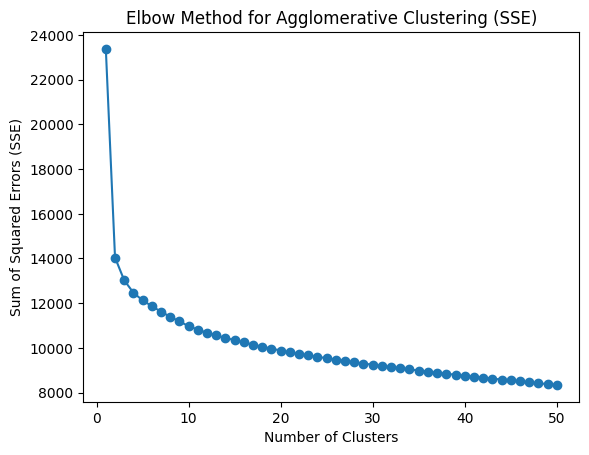

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

# Создаем синтетические данные

# Определяем функцию для вычисления SSE
def calculate_sse(X, labels):
    sse = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        sse += np.sum(np.linalg.norm(cluster_points - centroid, axis=1)**2)
    return sse

# Определяем функцию для метода локтя с использованием SSE
def elbow_method_sse(X, max_clusters=10):
    sse_values = []
    for n_clusters in range(1, max_clusters + 1):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(X)
        sse = calculate_sse(X, labels)
        sse_values.append(sse)

    return sse_values

# Вычисляем значения для метода локтя с использованием SSE
max_clusters = 50
sse_values = elbow_method_sse(X, max_clusters)

# Визуализация метода локтя с использованием SSE
plt.plot(range(1, max_clusters + 1), sse_values, marker='o')
plt.title('Elbow Method for Agglomerative Clustering (SSE)')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()


In [ ]:
# Выбираем оптимальное количество кластеров (например, на "локтевой" точке)
# optimal_clusters = 49
optimal_clusters = 30

# Выполнение иерархической кластеризации с косинусным сходством
model = AgglomerativeClustering(n_clusters=optimal_clusters, affinity='cosine', linkage='complete')
labels = model.fit_predict(X)

# Вывод результатов
print("Метки кластеров:", labels)

Метки кластеров: [14  4  2 ...  5 19 13]


Визуализируйте дендрограмму.

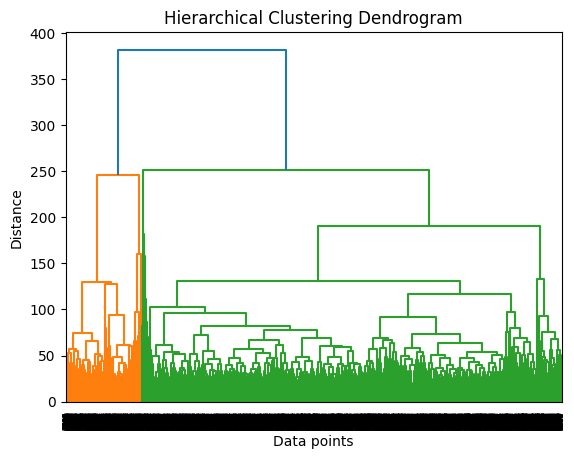

In [ ]:
from scipy.cluster.hierarchy import dendrogram

# Рассчитываем матрицу косинусных сходств
cosine_sim_matrix = np.dot(X, X.T)

# Выполнение иерархической кластеризации с косинусным сходством
Z = linkage(cosine_sim_matrix, 'complete')

# Построение дендрограммы
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

Оцените качество кластеризации.

In [ ]:
silhouette_avg = silhouette_score(X, labels)
print( "For n_clusters =",
      optimal_clusters,
       "The average silhouette_score is :",
       silhouette_avg,
       )

For n_clusters = 30 The average silhouette_score is : 0.08126552628824417


## Поиск "лишних" дисциплин

Эту часть выполните самостоятельно: постройте эмбеддинги для учебных планов по тому же принципу, по которому строили эмбеддинги для дисциплин. Затем проранжируйте все дисциплины в учебном плане по сходству с эмбеддингом плана. Выберите порог для значения сходства, ниже которого дисциплина считается "лишней".


Не нужно оценивать абсолютно все учебные планы из датасета. Можно выбрать около 10 случайных планов или тех, которые вам интересны. И оценить только их.

Обратите внимание, что типичнее для вашей выборки: малое или большое количество "лишних" дисциплин?

Проведите эксперимент: уберите из учебных планов все дисциплины, которые есть в каждом из них. Найдите "лишние" после удаления одинаковых. Оцените результат.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PDA_2023/df_milled.csv')
# df_first = pd.read_csv("/content/df_up_courses_202308.csv")

In [ ]:
df.head(3)

,course_id,course_title,qualification,unit_id,up_id,module_name,description_text,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,2626,Философия,bachelor,8.0,6905,Модуль «Философия+Мышление»,"['курс', 'философия', 'давать', 'целостный', '...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
1,2626,Философия,bachelor,8.0,6938,Модуль обязательных дисциплин,"['курс', 'философия', 'давать', 'целостный', '...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036
2,2626,Философия,bachelor,8.0,6974,Модуль обязательных дисциплин,"['курс', 'философия', 'давать', 'целостный', '...",0.015387,-0.351841,0.01015,...,-0.19808,0.097472,-0.172852,-0.18164,0.091139,-0.035487,0.009697,-0.057272,0.133714,-0.105036


In [ ]:
X = df.drop(columns=['qualification', 'unit_id', 'module_name', 'description_text'])

In [ ]:
def get_up_and_courses_datasets(X):
  X_up = X.drop(columns=['course_id', 'course_title']).groupby('up_id').mean().reset_index()
  X_up['embedding_up'] = X_up.drop(columns=['up_id']).apply(lambda row: row.tolist(), axis=1)
  X_up = X_up[['up_id', 'embedding_up']]

  X['embedding_course'] = X.drop(columns=['up_id', 'course_id', 'course_title']).apply(lambda row: row.tolist(), axis=1)
  X_courses = X[['course_id', 'course_title', 'up_id', 'embedding_course']]

  return X_up, X_courses

In [ ]:
X_up, X_courses = get_up_and_courses_datasets(X)

In [ ]:
X_courses.head(3)

,course_id,course_title,up_id,embedding_course
0,2626,Философия,6905,"[0.0153865087939345, -0.3518405444282309, 0.01..."
1,2626,Философия,6938,"[0.0153865087939345, -0.3518405444282309, 0.01..."
2,2626,Философия,6974,"[0.0153865087939345, -0.3518405444282309, 0.01..."


In [ ]:
X_up.head(3)

,up_id,embedding_up
0,6859,"[-0.12492582202985363, -0.22095110794559802, -..."
1,6860,"[-0.10427366520708753, -0.23982093536682747, -..."
2,6861,"[0.036610215743136075, -0.3078414939161685, 0...."


In [ ]:
df_embeddings = X_courses.merge(X_up, on='up_id', how='left')
df_embeddings.head()

,course_id,course_title,up_id,embedding_course,embedding_up
0,2626,Философия,6905,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.08269563970447716, -0.2599004094438733, -0..."
1,2626,Философия,6938,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.07496267925254793, -0.283087178555468, -0...."
2,2626,Философия,6974,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.07387103183534804, -0.2919175558213433, -0..."
3,2626,Философия,7014,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.07165343907949681, -0.282539102379358, -0...."
4,2626,Философия,7136,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.06972338104918645, -0.29874679825827544, -..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(df_embeddings):
  cosine_sims = [cosine_similarity(np.array(embedding1).reshape(1, -1), np.array(embedding2).reshape(1, -1))[0, 0]
               for embedding1, embedding2 in zip(df_embeddings['embedding_course'], df_embeddings['embedding_up'])]

  df_embeddings['cosine_similarity'] = cosine_sims
  return df_embeddings

In [ ]:
df_embeddings = calculate_cosine_similarity(df_embeddings)
df_embeddings.head(3)

,course_id,course_title,up_id,embedding_course,embedding_up,cosine_similarity
0,2626,Философия,6905,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.08269563970447716, -0.2599004094438733, -0...",0.837419
1,2626,Философия,6938,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.07496267925254793, -0.283087178555468, -0....",0.843240
2,2626,Философия,6974,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.07387103183534804, -0.2919175558213433, -0...",0.838149


In [ ]:
test_list_up = list(df_embeddings.up_id.sample(10))
border = 0.8

In [ ]:
# df_first[df_first.up_id == test_list_up[0]].up_title.iloc[0]

In [ ]:
df_embeddings[df_embeddings.up_id == test_list_up[0]].sort_values(by='cosine_similarity')

,course_id,course_title,up_id,embedding_course,embedding_up,cosine_similarity
61655,22704,Академическое письмо для молодых исследователе...,7243,"[0.1551298574841284, -0.4323488853789948, 0.30...","[-0.05378509317950644, -0.28687542589720527, -...",0.501436
53201,22672,IELTS и основы академического обучения / IELTS...,7243,"[0.0293487223072184, -0.615743412103297, 0.255...","[-0.05378509317950644, -0.28687542589720527, -...",0.515444
49802,22659,Составление деловых писем на английском языке:...,7243,"[-0.009014599899083, -0.4868252824195718, 0.31...","[-0.05378509317950644, -0.28687542589720527, -...",0.526610
52583,22670,Лаборатория академического письма / Academic W...,7243,"[0.1952461567924958, -0.3373771507780407, 0.18...","[-0.05378509317950644, -0.28687542589720527, -...",0.540917
48942,22656,Грамматика английского языка / Grammar Studies,7243,"[-0.0208198062987444, -0.727786723524332, 0.28...","[-0.05378509317950644, -0.28687542589720527, -...",0.545537
...,...,...,...,...,...,...
43825,20966,Коммерциализация инноваций,7243,"[0.0185525940666328, -0.2376605704768643, -0.0...","[-0.05378509317950644, -0.28687542589720527, -...",0.915939
5664,4035,Психология социальной адаптации и психосаморег...,7243,"[0.0144950121147857, -0.2949364281307604, -0.0...","[-0.05378509317950644, -0.28687542589720527, -...",0.917817
5026,3860,Управление инновационными проектами,7243,"[-0.0122593312936064, -0.2142373886161687, -0....","[-0.05378509317950644, -0.28687542589720527, -...",0.920246
5419,4025,Коммуникации и командообразование,7243,"[-0.0304505383542294, -0.2510649773623819, -0....","[-0.05378509317950644, -0.28687542589720527, -...",0.922886


In [ ]:
def get_right_and_wrong_lables(test_list_up, df_embeddings):
  final_df = pd.DataFrame(columns=['up_id', 'right_labeles, %', 'wrong_labeles, %'])
  for up_id in test_list_up:
    if up_id in list(df_embeddings.up_id.unique()):
      temp = df_embeddings[df_embeddings.up_id == up_id]
      final_df.loc[len(final_df.index)] = [up_id,
                                    round((temp[temp.cosine_similarity > border].shape[0] / temp.shape[0] * 100), 2),
                                    round((temp[temp.cosine_similarity <= border].shape[0] / temp.shape[0] * 100), 2)]
  return final_df

In [ ]:
labeles_df = get_right_and_wrong_lables(test_list_up, df_embeddings)
labeles_df

In [ ]:
df.up_id.nunique()

514

In [ ]:
df_gr = df.groupby('course_id').agg({'up_id': 'count'}).reset_index()

In [ ]:
df_gr[df_gr.up_id > 1].shape[0] / df_gr.shape[0] * 100

57.68474290531048

Без дубликатов:

In [ ]:
unique_counts = df.groupby('course_id')['up_id'].nunique()
filtered_course_ids = unique_counts[unique_counts > 1].index.tolist()
print(filtered_course_ids)

[2626, 2628, 2631, 2635, 2637, 2640, 2641, 2642, 2643, 2646, 2647, 2649, 2651, 2652, 2653, 2654, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2665, 2666, 2667, 2668, 2670, 2671, 2672, 2674, 2676, 2677, 2678, 2684, 2698, 2699, 2723, 2724, 2725, 2726, 2729, 2734, 2735, 2736, 2737, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2749, 2750, 2751, 2752, 2754, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2800, 2802, 2803, 2811, 2812, 2814, 2821, 2823, 2829, 2830, 2833, 2836, 2838, 2839, 2841, 2843, 2854, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2871, 2874, 2879, 2880, 2886, 2888, 2894, 2899, 2906, 2908, 2917, 2918, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2954, 2955, 2956, 2957, 2961, 2962, 2963, 2968, 2972, 2977, 2978, 2985, 2986, 298

In [ ]:
df_to_clear = df[df.course_id.isin(filtered_course_ids)]
df_clear = df[~df.course_id.isin(filtered_course_ids)]

df_to_clear = df.drop_duplicates('course_id')

df_no_duples = pd.concat([df_to_clear, df_clear])

In [ ]:
# df_no_duples = df.drop_duplicates('course_id')
# f"{df.shape} -> {df_no_duples.shape}"

In [ ]:
X_no_duples = df_no_duples.drop(columns=['course_title', 'qualification', 'unit_id', 'module_name', 'description_text'])

In [ ]:
X_no_duples.columns

Index(['course_id', 'up_id', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=202)

In [ ]:
X_up, X_courses = get_up_and_courses_datasets(X_no_duples)

In [ ]:
df_embeddings_no_duples = X_courses.merge(X_up, on='up_id', how='left')
df_embeddings_no_duples.head(3)

,course_id,up_id,embedding_course,embedding_up
0,2626,6905,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.13578384678258287, -0.2480399756375043, -0..."
1,2627,7146,"[0.0212762598993971, -0.3417820155421006, -0.1...","[-0.11079016125268845, -0.17873910278627061, -..."
2,2628,6881,"[-0.134248794345054, -0.3619245408024166, -0.1...","[-0.11480185795159083, -0.2731336940302668, -0..."


In [ ]:
df_embeddings_no_duples.shape

(10357, 5)

In [ ]:
df_embeddings_no_duples = calculate_cosine_similarity(df_embeddings_no_duples)
df_embeddings_no_duples.head(3)

,course_id,up_id,embedding_course,embedding_up,cosine_similarity
0,2626,6905,"[0.0153865087939345, -0.3518405444282309, 0.01...","[-0.13578384678258287, -0.2480399756375043, -0...",0.788334
1,2627,7146,"[0.0212762598993971, -0.3417820155421006, -0.1...","[-0.11079016125268845, -0.17873910278627061, -...",0.813946
2,2628,6881,"[-0.134248794345054, -0.3619245408024166, -0.1...","[-0.11480185795159083, -0.2731336940302668, -0...",0.821607


In [ ]:
labeles_df = get_right_and_wrong_lables(test_list_up, df_embeddings_no_duples)
labeles_df

,up_id,"right_labeles, %","wrong_labeles, %"
0,7218.0,94.74,5.26
1,6972.0,100.00,0.00
2,7026.0,100.00,0.00
3,6917.0,93.41,6.59
4,7296.0,100.00,0.00
5,7028.0,100.00,0.00
6,7006.0,100.00,0.00
7,6882.0,100.00,0.00
8,7242.0,76.39,23.61


## Генерация содержания

В этой части работы вам предлагается повторить пайплайн дообучения модели [LLaMA](https://github.com/facebookresearch/llama) (LLM с открытым исходным кодом) из туториала: https://colab.research.google.com/drive/1tG9eqttfnqHoQqmsiacywUG9ilUhoiCk?usp=sharing#scrollTo=qL5i358PRGgu

С текстовым описанием: https://www.datacamp.com/tutorial/fine-tuning-llama-2

Если памяти или ресурсов колаба не хватит, то попробуйте без дообучения. Но результат будет хуже.

Выберите 10-15 дисциплин (случайных или интересных вам) и с помощью модели сгенерируйте возможное описание дисциплины.

Постройте эмбеддинг для полученного описания. Оцените близость полученного эмбеддинга и того, что у вас уже был с момента создания word2vec.

Среди выбранных вами дисциплин найдите те, которые реализуются больше одного года. Изучите их следующим образом:

1. Оцените, насколько содержательно близки дисциплины разных лет.
2. Оцените, к дисциплине какого года ближе всего сгенерированное содержание.

### Создание модели

In [15]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl

In [16]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning:

The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.



In [17]:
# Model from Hugging Face hub
base_model = "NousResearch/Llama-2-7b-chat-hf"

# Fine-tuned model
new_model = "llama-2-7b-chat-guanaco"

In [18]:
# New instruction dataset
our_dataset = grouped_df["description_text"].drop_duplicates(keep="first")
our_dataset.shape

(5381,)

In [19]:
our_dataset.to_csv('our_dataset.csv', index=False)

dataset = load_dataset('csv', data_files='our_dataset.csv', split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

Это просто какая-то фантастика, но насколько я понял коллаб на gpu и на cpu используют разные версии трансформеров...

In [ ]:
!pip install --upgrade transformers

In [21]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning:

`do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning:

`do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.



In [22]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [23]:
# Load LoRA configuration
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [24]:
# Set training parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [25]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_args,
    dataset_text_field="description_text",
    max_seq_length=128,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

Map:   0%|          | 0/5381 [00:00<?, ? examples/s]

Очередна итерация издевательства с перекидывание с cpu на gpu

In [26]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,2.231500
50,1.965700
75,1.868300
100,1.827400
125,1.734600
150,1.762700
175,1.644500
200,1.746400
225,1.772700
250,1.683900


TrainOutput(global_step=1345, training_loss=1.6738002138953227, metrics={'train_runtime': 7865.1166, 'train_samples_per_second': 0.684, 'train_steps_per_second': 0.171, 'total_flos': 2.725998332490547e+16, 'train_loss': 1.6738002138953227, 'epoch': 1.0})

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

### Работа с моделью

In [27]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Современные вопросы информатики"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning:

You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )



<s>[INST] Современные вопросы информатики [/INST]  Современные вопросы информатики - это сложный и многогранный вопрос, который включает в себя множество разных аспектов, связанных с изучением и применением информационных технологий.

В рамках данного курса мы рассмотрим некоторые из них:

1. Теория алгоритмов и структур данных.
2. Теория информации и кодирования.
3. Теория сетей и сетевых протоколов.
4. Теория искусственного интеллекта и машинного обучения.
5. Теория компьютерной графики и визуализации.
6. Теория компьютерной сети и сетевых протоколов.
7


In [41]:
df_for_promts = grouped_df["course_title"].unique()[:15]

In [46]:
df_for_promts

array(['Философия', 'Введение в цифровую культуру и программирование',
       'Проектирование баз данных', 'Современные вопросы информатики',
       'Иностранный язык',
       'Техники публичных выступлений, переговоров и презентаций. Деловая коммуникация',
       'Теория автоматического управления',
       'Основы проектирования киберфизических систем',
       'Методы и средства программного обеспечения',
       'Основы кибербезопасности',
       'Современные инструменты анализа данных',
       'UNIX/Linux системы в инфокоммуникациях', 'Алгоритмы на графах',
       'Лазерные технологии', 'Линейная алгебра'], dtype=object)

In [48]:
prompt_ans = []

for prompt in df_for_promts:
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
  result = pipe(f"<s>[INST] {prompt} [/INST]")
  prompt_ans.append(result[0]['generated_text'])

prompt_ans

['<s>[INST] Философия [/INST]  Философия - это раздел науки, изучающий основные вопросы существования, природы и цели человеческой жизни. В рамках философии изучаются такие темы, как:\n\n1. Этика: изучение моральных принципов и норм, которые определяют поведение человека в обществе.\n2. Политика: изучение государственного устройства и политических систем.\n3. Экономика: изучение экономических законов и принципов, которые определяют экономическую сферу общества.\n4. Теория познания: изучение способам и методам познания мира и человека.\n5. Теория идей: изучение источников идей, их развития и влияния на',
 '<s>[INST] Введение в цифровую культуру и программирование [/INST]  Введение в цифровую культуру и программирование - это курс, который направлен на освоение студентами основных концепций цифровой культуры и программирования. В курсе рассматриваются основные понятия цифровой культуры, такие как цифровая культура, цифровая экономика, цифровая политика, цифровая экосистема, цифровая экол

In [114]:
class Word2VecTransformer2:

    def __init__(self, w2v_model, word_pattern=r'\b\w+\b'):

        self.w2v_model = w2v_model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):

        X_transformed = np.zeros((len(X), self.w2v_model.wv.vector_size))
        for i, title in enumerate(X):

            title_vector = np.zeros((self.w2v_model.wv.vector_size,))
            tokens = self.re.findall(title)
            if len(tokens) == 0:
              continue

            for token in tokens:
                token = token.lower()
                if token in self.w2v_model.wv.key_to_index:
                    title_vector += self.w2v_model.wv.get_vector(token)

            X_transformed[i] = title_vector / len(tokens)

        return X_transformed

w2v_transformer2 = Word2VecTransformer2(w2v_model=model_w2v)

In [115]:
embeding_prompts = w2v_transformer2.transform(prompt_ans)
embeding_prompts

array([[ 0.04093731, -0.05941667,  0.03042368, ..., -0.0139384 ,
         0.00410776, -0.083345  ],
       [ 0.01097042, -0.04096007, -0.03307658, ..., -0.08473761,
         0.02060186, -0.10483045],
       [ 0.01161113, -0.01571524,  0.00083115, ..., -0.02050006,
         0.00322701, -0.02611385],
       ...,
       [ 0.00229706, -0.02214511,  0.04141424, ..., -0.00895507,
        -0.0049192 , -0.02026514],
       [ 0.00713032, -0.04656013,  0.02279013, ...,  0.03919546,
        -0.0327627 ,  0.00651063],
       [-0.00927468, -0.01716007,  0.00771041, ...,  0.00760679,
         0.00095043, -0.01697451]])

In [116]:
prompt_check_df = grouped_df.groupby("course_title").agg({"description_text": "first"}).reset_index()
prompt_check_df = prompt_check_df[prompt_check_df["course_title"].isin(df_for_promts)]
prompt_check_df

,course_title,description_text
39,UNIX/Linux системы в инфокоммуникациях,В этом курсе вы изучите фундаментальные принци...
138,Алгоритмы на графах,nan Построение остовных деревьев Раскраски гра...
443,Введение в цифровую культуру и программирование,"Курс ""Введение в цифровую культуру и программи..."
823,Иностранный язык,Целью освоения дисциплины является достижение ...
1217,Лазерные технологии,Целью освоения дисциплины «Лазерные технологии...
1224,Линейная алгебра,В результате освоения курса студенты получат п...
1472,Методы и средства программного обеспечения,Дициплина предназначена для изучения студентам...
2091,Основы кибербезопасности,В данном курсе студенты ознакомятся с местом и...
2160,Основы проектирования киберфизических систем,Что общего между умным чайником и металлургиче...
2563,Проектирование баз данных,Дисциплина направлена на формирование понимани...


In [117]:
prompt_check = []

for course_title in df_for_promts:
  temp = prompt_check_df[prompt_check_df["course_title"] == course_title]
  prompt_check.append(str(temp["description_text"].values))
prompt_check[:1]

["['Курс «Философия» даёт целостное представление о специфике философии как актуальной формы мышления, о месте и роли философствования в различных средах: повседневной, социальной, коммуникационной, научной.Этот курс для тех, кто хочет узнать, к примеру, о том, что осталось в нашем мышлении неизменным со времен античности, и почему наука, какой мы знаем ее сегодня, не появилась бы без Декарта. Философия для тех, кому важно знать, как избавиться от ошибочных суждений, развить критическое мышление и попробовать себя в роли мастера аргументации в режиме и оффлайн, и онлайн. Мышление и предметный мир Соматическая определенность мышления Социальная определенность мышления Структуры мышления Способы и границы систематизации предметов мышления: логика, категориальные структуры. Этическое измерение науки, искусства, повседневности. Техники управления, контроля, манипуляции: возможности распознавания, практики сопротивления. Критическое мышление как задача философии, науки, искусства, повседнев

In [118]:
embeding_check_prompts = w2v_transformer2.transform(prompt_check)
embeding_check_prompts

array([[-0.0060769 , -0.06747717, -0.0006747 , ..., -0.0151079 ,
        -0.02695384, -0.09318478],
       [-0.06293845, -0.06245691,  0.02252917, ..., -0.0128053 ,
        -0.04239848, -0.0461136 ],
       [-0.15153359, -0.09594315,  0.0936208 , ..., -0.04359419,
         0.03149203, -0.08671402],
       ...,
       [-0.04544934, -0.02372605,  0.02742047, ..., -0.00711587,
        -0.02511125, -0.04300212],
       [-0.01267134, -0.01943852,  0.04411063, ..., -0.00649721,
         0.02167098, -0.0343981 ],
       [-0.01610509, -0.03350957,  0.02465909, ...,  0.01849652,
        -0.00131756, -0.05515799]])

In [119]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

cosin_ans = []

embeding_prompts_norm = normalize(embeding_prompts)
embeding_check_prompts_norm = normalize(embeding_check_prompts)

for i in range(15):
  cosin_ans.append(cosine_similarity([embeding_prompts_norm[i, :]], [embeding_check_prompts_norm[i, :]])[0, 0])

cosin_ans

[0.7206857628644532,
 0.467047012257607,
 0.44935731819947294,
 0.5321193836423579,
 0.5946943807977724,
 0.6268935748402965,
 0.542253807490743,
 0.5286043428372513,
 0.3966324164070792,
 0.7209392236220568,
 0.7175523965917947,
 0.9190205659014936,
 0.5248509798129437,
 0.6492545859943433,
 0.6824653115411602]

### Годы

In [120]:
prompt_year_check_df = df.groupby(["course_title", "start_year"]).agg({"description": "last", "section": "last", "topic": "last"}).reset_index()
prompt_year_check_df = prompt_year_check_df[prompt_year_check_df["course_title"].isin(df_for_promts)]
prompt_year_check_df["description_text"] = prompt_year_check_df['description'] + ' ' + prompt_year_check_df['section'] + ' ' + prompt_year_check_df['topic']
prompt_year_check_df = prompt_year_check_df.drop(['description', 'section', 'topic'], axis = 1)
prompt_year_check_df.tail(6)

,course_title,start_year,description_text
7384,"Техники публичных выступлений, переговоров и п...",2018,Данный курс сформирован на основе лучших дост...
8220,Философия,2018,Курс «Философия» даёт целостное представление ...
8221,Философия,2019,Курс «Философия» даёт целостное представление ...
8222,Философия,2020,Курс «Философия» даёт целостное представление ...
8223,Философия,2021,Курс «Философия» даёт целостное представление ...
8224,Философия,2022,Курс «Философия» даёт целостное представление ...


In [124]:
for i, course_title in enumerate(df_for_promts):
  years = prompt_year_check_df[prompt_year_check_df["course_title"] == course_title]["description_text"]
  cur_cosin = []
  #print(len(years.values))
  for year in years.values:
    emb = w2v_transformer2.transform([str(year)])
    emb = normalize(emb)
    #print(str(year))
    calc_cos = cosine_similarity([embeding_prompts_norm[i, :]], emb)[0, 0]
    cur_cosin.append(calc_cos.round(3))
  print(f'Cosine dist for {course_title}: {cur_cosin}')

Cosine dist for Философия: [0.691, 0.691, 0.691, 0.691, 0.702]
Cosine dist for Введение в цифровую культуру и программирование: [0.298, 0.298, 0.298, 0.495, 0.652]
Cosine dist for Проектирование баз данных: [0.492, 0.492, 0.492, 0.492, 0.471]
Cosine dist for Современные вопросы информатики: [0.53, 0.53, 0.53, 0.46]
Cosine dist for Иностранный язык: [0.719, 0.575, 0.575, 0.575, 0.581]
Cosine dist for Техники публичных выступлений, переговоров и презентаций. Деловая коммуникация: [0.597]
Cosine dist for Теория автоматического управления: [0.536, 0.703, 0.703, 0.703, 0.505]
Cosine dist for Основы проектирования киберфизических систем: [0.534, 0.534, 0.534, 0.534]
Cosine dist for Методы и средства программного обеспечения: [0.541, 0.541, 0.541, 0.541]
Cosine dist for Основы кибербезопасности: [0.737, 0.737, 0.737, 0.565, 0.565]
Cosine dist for Современные инструменты анализа данных: [0.74, 0.74, 0.74, 0.74, 0.75]
Cosine dist for UNIX/Linux системы в инфокоммуникациях: [0.922, 0.922, 0.922,